# Two Step Forecasting for weather and kWh delivered using TransCN

In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model.

In summary, I will be exploring three methods:

1. Using historical weather data from only one charging station to predict kWhDelivered
2. Using historical weather data from 54 charging stations with cummulative kWhDelivered added based on stationID
3. Using historical data for each 54 charging stations using Transfer Learning

# First step Forecasting

Predicting future weather data and testing the accuracy of the GRU model

In [ ]:
# Import necessary packages

In [31]:
import os
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from smape import smape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LayerNormalization, MultiHeadAttention

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *

# Make the process reproducible using a seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

# Limit TensorFlow to a single thread
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

In [ ]:
# Load the weather data from the weather data folder

In [32]:
folder_path = './caltech_weather_data'
data_frames = []

# Function to safely extract data from JSON
def extract_hourly_data(data):
    historical_data = data.get('historical', {})
    for date, details in historical_data.items():
        hourly_data = details.get('hourly', [])
        for hour_data in hourly_data:
            hour_data['date'] = date
            data_frames.append(hour_data)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path) as file:
                data = json.load(file)
                extract_hourly_data(data)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_name}: {e}")

df = pd.DataFrame(data_frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)


weather_df = pd.DataFrame(data_frames)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.sort_values('date', inplace=True)

# Select relevant features
weather_features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
weather_df = weather_df[weather_features + ['date']]

# Aggregate weather data by day (since kWh data is monthly, daily aggregation should be sufficient)
weather_daily_df = weather_df.groupby('date').mean().reset_index()

In [ ]:
# Select relevant features

In [33]:
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
df = df[features + ['date']]

In [ ]:
# Normalize the data and split into training and testing sets

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences for GRU
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
scaled_data

array([[0.30232558, 0.1875    , 0.5       , 0.4787234 , 0.        ],
       [0.27906977, 0.125     , 0.46875   , 0.58510638, 0.        ],
       [0.27906977, 0.1875    , 0.46875   , 0.56382979, 0.        ],
       ...,
       [0.37209302, 0.0625    , 0.4375    , 0.62765957, 0.        ],
       [0.58139535, 0.46875   , 0.40625   , 0.30851064, 0.        ],
       [0.37209302, 0.0625    , 0.4375    , 0.61702128, 0.        ]])

In [ ]:
# Build a TCN using the data from the model

In [51]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)  # Match the output dimension with key_dim for residual connection
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def build(self, input_shape):
        # Ensure the layer is built with the correct input shape
        super(TransformerEncoder, self).build(input_shape)

    def call(self, inputs, training=False):
        # Self-attention
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual connection

# Define the TransCN model
def build_transcn_model(input_shape, num_heads, key_dim, ff_dim, dropout_rate, num_classes):
    inputs = Input(shape=input_shape)
    
    # Convolutional Layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    # Transformer Encoder Block
    x = TransformerEncoder(num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_rate)(x)
    
    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [23]:
# Evaluate the model and check for accuracy

In [52]:
# Make predictions
input_shape = (30, 5)  # Adjusted input shape to match your data
num_heads = 4
key_dim = 5  # Adjusted key dimension to match the input's last dimension
ff_dim = 64  # Feed-forward network dimension
dropout_rate = 0.2
num_classes = 1  # For regression, set to 1


# Build and compile the model
model = build_transcn_model(input_shape, num_heads, key_dim, ff_dim, dropout_rate, num_classes)


y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluate the model for each feature
mae_per_feature = []
mse_per_feature = []

for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mse = mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mae_per_feature.append(mae)
    mse_per_feature.append(mse)
    print(f'{feature.capitalize()} - Mean Absolute Error: {mae}')
    print(f'{feature.capitalize()} - Mean Squared Error: {mse}')

ValueError: Exception encountered when calling TransformerEncoder.call().

[1mCould not automatically infer the output shape / dtype of 'transformer_encoder_16' (of type TransformerEncoder). Either the `TransformerEncoder.call()` method is incorrect, or you need to implement the `TransformerEncoder.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 64 and 5 for '{{node add_1}} = AddV2[T=DT_FLOAT](layer_normalization_32_1/add_2, sequential_16_1/dense_39_1/Add)' with input shapes: [?,14,64], [?,14,5].[0m

Arguments received by TransformerEncoder.call():
  • args=('<KerasTensor shape=(None, 14, 64), dtype=float32, sparse=False, name=keras_tensor_130>',)
  • kwargs={'training': 'False'}

In [ ]:
#Plot the results

NameError: name 'y_test_inverse' is not defined

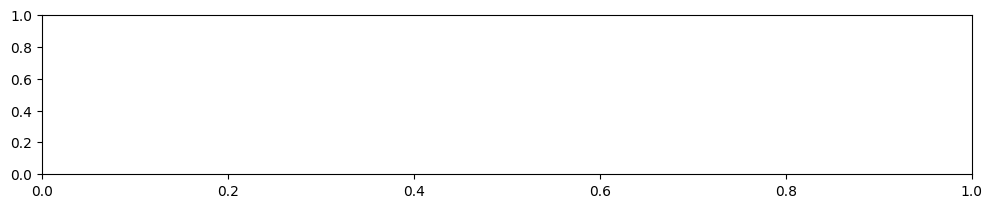

In [40]:
# Plot Actual vs Predicted for all features
plt.figure(figsize=(12, 12))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, i], color='blue', label=f'Actual {feature.capitalize()}')
    plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, i], color='red', label=f'Predicted {feature.capitalize()}')
    plt.title(f'{feature.capitalize()} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

# Second step

Using the forecasted weather data to predict future kWh delivered by electric vehicle charging stations

## Method 1: Using historical weather data from only one charging station to predict kWhDelivered

In [ ]:
# Load the model data for single charging station
data = pd.read_csv('./caltech_model_data/2-39-123-23.csv')
data.head()

In [ ]:
# Convert the month to datetime format and set it as the index
data['Month'] = pd.to_datetime(data['month'])
data.set_index('Month', inplace=True)

In [ ]:
# Select the features (weather data) and target variable (kWhDelivered)
features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
target = 'kWhDelivered'

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[features])

# Scale the target variable (kWhDelivered) separately
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(data[[target]])  # Use double brackets to keep it as a DataFrame
data['Scaled_kWhDelivered'] = scaled_target

In [ ]:
# Convert the scaled features back to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)

# Combine the scaled features with the scaled target variable
scaled_data = pd.concat([scaled_features_df, data['Scaled_kWhDelivered']], axis=1)

# Create a lagged feature for kWhDelivered
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Set the sequence length (e.g., 1 for 1 months of data)
sequence_length = 1

# Create sequences and targets
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
# Split the data into training and testing sets (use all except the last one for training)
X_train, X_test = X[:-1], X[-1:]
y_train, y_test = y[:-1], y[-1:]

# Extract the months corresponding to the training and test data
months_train = data.index[sequence_length:len(X_train)+sequence_length]
months_test = data.index[-len(X_test):]

# Define the GRU model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

In [ ]:
# Predict the values for both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
y_train_scaled = y_train.reshape(-1, 1)
y_test_scaled = y_test.reshape(-1, 1)
y_train_pred_scaled = y_train_pred.reshape(-1, 1)
y_test_pred_scaled = y_test_pred.reshape(-1, 1)

# Inverse transform the predictions and actual values using the target scaler
y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)

# Plot the actual vs predicted values against the month for both training and test sets
plt.figure(figsize=(12, 8))

# Plot training data
plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')

# Plot test data
plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')

plt.title('Actual vs Predicted kWhDelivered (Training and Test)')
plt.xlabel('Month')
plt.ylabel('kWhDelivered')
plt.legend()
plt.show()

In [ ]:
# Define the metrics
mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
smape_value = smape(y_test_inversed, y_test_pred_inversed)

print(f'Mean Squared Error: {round(mse,2)}')
print(f'Mean Absolute Error: {round(mae,2)}')
print(f'Symmetric Mean Absolute Percentage Error: {round(smape_value,2)}%')

## Method 2: Making Predictions with GRU using historical weather data from 54 charging stations with cummulative kWhDelivered

In [ ]:
directory = './caltech_model_data'

In [ ]:
combined_data = pd.DataFrame()


# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        # Append the data to the combined DataFrame
        combined_data = pd.concat([combined_data, data], axis=0)

summed_data = combined_data.groupby('month').agg({
    'kWhDelivered': 'sum',
    'MinTemp': 'first',
    'MaxTemp': 'first',
    'AvgTemp': 'first',
    'AvgPrecipitation': 'first',
    'AvgHumidity': 'first',
    'AvgWindSpeed': 'first'
}).reset_index()

# Print or save the result
summed_data.head()

In [ ]:
# Convert the month to datetime format and set it as the index
summed_data['Month'] = pd.to_datetime(summed_data['month'])
summed_data.set_index('Month', inplace=True)

In [ ]:
# Select the features (weather data) and target variable (kWhDelivered)
features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
target = 'kWhDelivered'

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(summed_data[features])

# Scale the target variable (kWhDelivered) separately
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(summed_data[[target]])  # Use double brackets to keep it as a DataFrame
summed_data['Scaled_kWhDelivered'] = scaled_target

In [ ]:
# Convert the scaled features back to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=summed_data.index)

# Combine the scaled features with the scaled target variable
scaled_data = pd.concat([scaled_features_df, summed_data['Scaled_kWhDelivered']], axis=1)

# Create a lagged feature for kWhDelivered
def create_sequences(summed_data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(summed_data) - sequence_length):
        seq = summed_data.iloc[i:i+sequence_length][features].values
        label = summed_data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Set the sequence length (e.g., 3 for 3 months of data)
sequence_length = 3

# Create sequences and targets
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
# Split the data into training and testing sets (use all except the last one for training)
X_train, X_test = X[:-1], X[-1:]
y_train, y_test = y[:-1], y[-1:]

# Extract the months corresponding to the training and test data
months_train = summed_data.index[sequence_length:len(X_train)+sequence_length]
months_test = summed_data.index[-len(X_test):]

# Define the GRU model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

In [ ]:
# Predict the values for both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
y_train_scaled = y_train.reshape(-1, 1)
y_test_scaled = y_test.reshape(-1, 1)
y_train_pred_scaled = y_train_pred.reshape(-1, 1)
y_test_pred_scaled = y_test_pred.reshape(-1, 1)

# Inverse transform the predictions and actual values using the target scaler
y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)

# Plot the actual vs predicted values against the month for both training and test sets
plt.figure(figsize=(12, 8))

# Plot training data
plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')

# Plot test data
plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')

plt.title('Actual vs Predicted kWhDelivered (Training and Test)')
plt.xlabel('Month')
plt.ylabel('kWhDelivered')
plt.legend()
plt.show()

In [ ]:
# Define the metrics
mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
smape_value = smape(y_test_inversed, y_test_pred_inversed)

print(f'Mean Squared Error: {round(mse,2)}')
print(f'Mean Absolute Error: {round(mae,2)}')
print(f'Symmetric Mean Absolute Percentage Error: {round(smape_value,2)}%')

## Method 3: Making Predictions with GRU using historical weather data for each 54 charging stations with Transfer Learning

### With Transfer Learning

In [ ]:
# Initialize a dictionary to store the models and metrics
models = {}
metrics = {}

# Directory containing the CSV files
directory = "./caltech_model_data"  # Replace with your directory path

# List all files in the directory
filenames = sorted([filename for filename in os.listdir(directory) if filename.endswith('.csv')])

# Placeholder to store the first trained model for Transfer Learning
previous_model = None

def prepare_data(features, target):
    # For window_size = 1, each sample is its own sequence
    return features, target

def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def inverse_transform(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1)).flatten()

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Loop through each CSV file in the directory
for filename in filenames:
    try:
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        
        # Convert the month to datetime format and set it as the index
        data['Month'] = pd.to_datetime(data['month'])
        data.set_index('Month', inplace=True)
    
        # Select the features (weather data) and target variable (kWhDelivered)
        stationID = filename.split('.')[0]  # Example: If filename is 'station1.csv'
        features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
        target = 'kWhDelivered'
    
        # Scale the features
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(data[features])
    
        # Scale the target variable (kWhDelivered) separately
        target_scaler = MinMaxScaler()
        scaled_target = target_scaler.fit_transform(data[[target]])  # Use double brackets to keep it as a DataFrame
        data['Scaled_kWhDelivered'] = scaled_target
    
        # Convert the scaled features back to a DataFrame
        scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
    
        # Combine the scaled features with the scaled target variable
        scaled_data = pd.concat([scaled_features_df, data['Scaled_kWhDelivered']], axis=1)
    
        # Set the sequence length (e.g., 1 for 1 months of data)
        sequence_length = 1
    
        # Create sequences and targets
        X, y = create_sequences(scaled_data, sequence_length)
    
        # Split the data into training and testing sets (use all except the last one for training)
        X_train, X_test = X[:-1], X[-1:]
        y_train, y_test = y[:-1], y[-1:]
    
        # Extract the months corresponding to the training and test data
        months_train = data.index[sequence_length:len(X_train)+sequence_length]
        months_test = data.index[-len(X_test):]
    
        # Define the GRU model
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_gru_model(input_shape)
    
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())
    
        # If there is a previously trained model, load its weights for transfer learning
        if previous_model is not None:
            model.set_weights(previous_model.get_weights())  # Transfer weights from previous model
        
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
       
        # Predict the values for both training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
        # Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
        y_train_scaled = y_train.reshape(-1, 1)
        y_test_scaled = y_test.reshape(-1, 1)
        y_train_pred_scaled = y_train_pred.reshape(-1, 1)
        y_test_pred_scaled = y_test_pred.reshape(-1, 1)
    
        # Inverse transform the predictions and actual values using the target scaler
        y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
        y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
        y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
        y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)
    
        mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
        mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
        smape_value = smape(y_test_inversed, y_test_pred_inversed)
        
        # Store the model and metrics
        models[stationID] = model
        metrics[stationID] = {
            'MAE': mae,
            'MSE': mse,
            'SMAPE (%)': smape_value,
            'Actual kWh': y_test_inversed[0][0],
            'Predicted kWh': y_test_pred_inversed[0][0]
        }
    
        # Plot the actual vs predicted values against the month for both training and test sets
        plt.figure(figsize=(12, 8))
    
        # Plot training data
        plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
        plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')
    
        # Plot test data
        plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
        plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')
    
        plt.title(f'Actual vs Predicted kWhDelivered (Training and Test) for {stationID}')
        plt.xlabel('Month')
        plt.ylabel('kWhDelivered')
        plt.legend()
        plt.show()
    
        # Update the previous model for transfer learning
        previous_model = model
    except Exception as e:
        print(f"An error occurred with station {filename}: {e}")
        continue  # Skip to the next file if there's an error

In [ ]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()

# Rename the index column to 'stationID'
metrics_df = metrics_df.rename(columns={'index': 'stationID'})

metrics_df

### Without Transfer learning

In [ ]:
# Initialize a dictionary to store the models and metrics
models = {}
metrics = {}

# Directory containing the CSV files
directory = "./caltech_model_data"  # Replace with your directory path

# List all files in the directory
filenames = sorted([filename for filename in os.listdir(directory) if filename.endswith('.csv')])

# Placeholder to store the first trained model for Transfer Learning
previous_model = None

def prepare_data(features, target):
    # For window_size = 1, each sample is its own sequence
    return features, target

def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    return model

def inverse_transform(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1)).flatten()

# Create a lagged feature for kWhDelivered
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)



# Loop through each CSV file in the directory
for filename in filenames:
    try:
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        
        # Convert the month to datetime format and set it as the index
        data['Month'] = pd.to_datetime(data['month'])
        data.set_index('Month', inplace=True)
    
        # Select the features (weather data) and target variable (kWhDelivered)
        stationID = filename.split('.')[0]  # Example: If filename is 'station1.csv'
        features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
        target = 'kWhDelivered'
    
        # Scale the features
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(data[features])
    
        # Scale the target variable (kWhDelivered) separately
        target_scaler = MinMaxScaler()
        scaled_target = target_scaler.fit_transform(data[[target]])  # Use double brackets to keep it as a DataFrame
        data['Scaled_kWhDelivered'] = scaled_target
    
        # Convert the scaled features back to a DataFrame
        scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
    
        # Combine the scaled features with the scaled target variable
        scaled_data = pd.concat([scaled_features_df, data['Scaled_kWhDelivered']], axis=1)
    
        # Set the sequence length (e.g., 1 for 1 months of data)
        sequence_length = 1
    
        # Create sequences and targets
        X, y = create_sequences(scaled_data, sequence_length)
    
        # Split the data into training and testing sets (use all except the last one for training)
        X_train, X_test = X[:-1], X[-1:]
        y_train, y_test = y[:-1], y[-1:]
    
        # Extract the months corresponding to the training and test data
        months_train = data.index[sequence_length:len(X_train)+sequence_length]
        months_test = data.index[-len(X_test):]
    
        # Define the GRU model
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_gru_model(input_shape)
    
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
       
        # Predict the values for both training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
        # Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
        y_train_scaled = y_train.reshape(-1, 1)
        y_test_scaled = y_test.reshape(-1, 1)
        y_train_pred_scaled = y_train_pred.reshape(-1, 1)
        y_test_pred_scaled = y_test_pred.reshape(-1, 1)
    
        # Inverse transform the predictions and actual values using the target scaler
        y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
        y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
        y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
        y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)
    
    
        mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
        mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
        smape_value = smape(y_test_inversed, y_test_pred_inversed)
        
        # Store the model and metrics
        models[stationID] = model
        metrics[stationID] = {
            'MAE': mae,
            'MSE': mse,
            'SMAPE (%)': round(smape_value,2),
            'Actual kWh': y_test_inversed[0][0],
            'Predicted kWh': y_test_pred_inversed[0][0]
        }
    
        # Plot the actual vs predicted values against the month for both training and test sets
        plt.figure(figsize=(12, 8))
    
        # Plot training data
        plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
        plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')
    
        # Plot test data
        plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
        plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')
    
        plt.title(f'Actual vs Predicted kWhDelivered (Training and Test) for {stationID}')
        plt.xlabel('Month')
        plt.ylabel('kWhDelivered')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"An error occurred with station {filename}: {e}")
        continue  # Skip to the next file if there's an error

    

In [ ]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()

# Rename the index column to 'stationID'
metrics_df = metrics_df.rename(columns={'index': 'stationID'})

metrics_df